In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.io import read_image
from timm import create_model

import pytorch_lightning as pl
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import LightningDataModule

from sklearn.model_selection import StratifiedKFold

import glob

c:\Users\q\Desktop\Programming\ML\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\q\Desktop\Programming\ML\venv\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


We already have 2 directories, `train` and `test`. 

Let us check the number of test and train instances

In [45]:
data_dir = "data"

print(f"Number of training instances: {len(os.listdir(os.path.join(data_dir, 'train')))}")
print(f"Number of test instances: {len(os.listdir(os.path.join(data_dir, 'test')))}")

Number of training instances: 9912
Number of test instances: 8


In [49]:
class PetFinderDataset(Dataset):
    def __init__(self, df, image_dir, image_size=224):
        self.X = df["Id"].values
        self.y = None

        if "Pawpularity" in df.keys():
            self.y = df["Pawpularity"].values

        self.image_dir = image_dir
        self.transform = T.Resize([image_size, image_size])
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image_path = self.X[idx]
        image = read_image(os.path.join(self.image_dir, image_path + '.jpg'))
        image = self.transform(image)
        
        if self.y is not None:
            label = self.y[idx]
            return image, label
        
        return image, image_path

train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

class PetFinderDataModule(LightningDataModule):
    def __init__(self, df_train, df_val, df_test=None, train_dir=train_dir, val_dir=train_dir, test_dir=test_dir, batch_size=64):
        super().__init__()
        self.df_train = df_train
        self.df_val = df_val
        self.df_test = df_test

        self.train_dir = train_dir
        self.val_dir = val_dir
        self.test_dir = test_dir

        self.batch_size = batch_size

    def train_dataloader(self):
        return DataLoader(PetFinderDataset(self.df_train, self.train_dir), batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(PetFinderDataset(self.df_val, self.val_dir), batch_size=self.batch_size, shuffle=False) # not recommended to shuffle val/test dataloaders
    
    def test_dataloader(self):
        return DataLoader(PetFinderDataset(self.df_test, self.test_dir), batch_size=self.batch_size, shuffle=False) 


c:\Users\q\Desktop\Programming\ML\venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


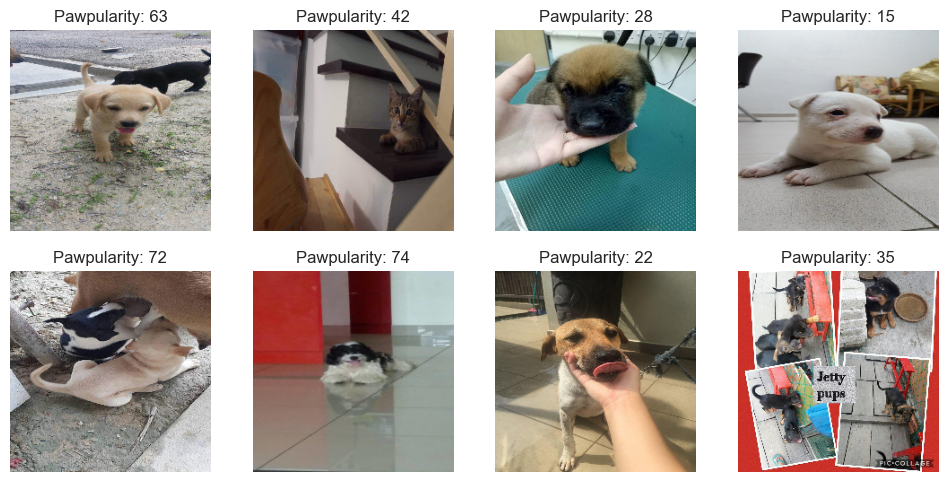

In [51]:
df = pd.read_csv(os.path.join(data_dir, 'train.csv'))

dataloader = PetFinderDataModule(df, df, batch_size=8).val_dataloader()
dataiter = iter(dataloader)
images, labels = next(dataiter)

plt.figure(figsize=(12, 12))
for it, (image, label) in enumerate(zip(images[:16], labels[:16])):
    plt.subplot(4, 4, it+1)
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f'Pawpularity: {int(label)}')

In [5]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]  # RGB
IMAGENET_STD = [0.229, 0.224, 0.225]  # RGB

train_transforms = T.Compose(
    [
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.RandomAffine(15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        T.ConvertImageDtype(torch.float),
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ]
)

test_transforms = T.Compose(
    [
        T.ConvertImageDtype(torch.float),
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ]
)

# https://arxiv.org/abs/1710.09412v2
def mixup(x: torch.Tensor, y: torch.Tensor, alpha: float = 1.0):
    assert alpha > 0, "alpha should be larger than 0"
    assert x.size(0) > 1, "Mixup cannot be applied to a single instance."

    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size()[0])
    mixed_x = lam * x + (1 - lam) * x[rand_index, :]
    target_a, target_b = y, y[rand_index]
    return mixed_x, target_a, target_b, lam

# Defining Model

In [6]:
class PawpularityModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.validation_step_outputs = []
        self.training_step_outputs = []

        self.backbone = create_model("swin_tiny_patch4_window7_224", pretrained=True, num_classes=0, in_chans=3)
        num_features = self.backbone.num_features
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 64),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )

        self.criterion = nn.MSELoss()
        self.train_transforms = train_transforms
        self.test_transforms = test_transforms
        
    def forward(self, input):
        return self.fc(self.backbone(input))

    def step(self, batch, mode):
        images, labels = batch
        labels = labels.float()
        images = self.train_transforms(images) if mode == "train" else self.test_transforms(images)

        if torch.rand(1)[0] < 0.5 and mode == 'train' and len(images) > 1:
            mix_images, target_a, target_b, lam = mixup(images, labels, alpha=0.5)
            logits = self.forward(mix_images).squeeze(1)
            loss = self.criterion(logits, target_a) * lam + (1 - lam) * self.criterion(logits, target_b)
        else:
            logits = self.forward(images).squeeze(1)
            loss = self.criterion(logits, labels)

        predictions = logits.detach().cpu()
        labels = labels.detach().cpu()

        self.log(f'{mode}_loss', loss)
        
        return loss, predictions, labels

    def training_step(self, batch, batch_indexes):
        loss, predictions, labels = self.step(batch, 'train')
        self.training_step_outputs.append(loss)
        return { 'loss': loss, 'predictions': predictions, 'labels': labels }

    def validation_step(self, batch, batch_indexes):
        loss, predictions, labels = self.step(batch, 'val')
        self.validation_step_outputs.append(loss)
        return { 'loss': loss, 'predictions': predictions, 'labels': labels }
    
    def on_train_epoch_end(self):
        print(f"Training loss: {torch.stack(self.training_step_outputs).mean()}")
        self.training_step_outputs.clear()

    def on_validation_epoch_end(self):
        print(f"Validation loss: {torch.stack(self.validation_step_outputs).mean()}")
        self.validation_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-5)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 20, eta_min=1e-4)

        return [optimizer], [scheduler]

In [7]:
skf = StratifiedKFold(n_splits=5, shuffle=True)

for fold, (train_idx, val_idx) in enumerate(skf.split(df["Id"], df["Pawpularity"])):
    df_train = df.loc[train_idx].reset_index(drop=True)
    df_val = df.loc[val_idx].reset_index(drop=True)

    data_module = PetFinderDataModule(df_train, df_val)
    model = PawpularityModel()

    early_stopping = EarlyStopping(monitor="val_loss")
    lr_monitor = callbacks.LearningRateMonitor()
    loss_checkpoint = callbacks.ModelCheckpoint(filename="best_loss", monitor="val_loss", save_top_k=1, mode="min", save_last=False)

    logger = TensorBoardLogger("logs/swin_224")

    trainer = pl.Trainer(max_epochs=50, callbacks=[lr_monitor, loss_checkpoint, early_stopping], logger=logger)
    trainer.fit(model, datamodule=data_module)

c:\Users\q\Desktop\Programming\ML\venv\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\q\Desktop\Programming\ML\venv\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/swin_224\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type            | Params
----------------------------------------------
0 | backbone  | SwinTransformer | 27.5 M
1 | fc        | Sequential      | 49.3 K
2 | criterion | MSELoss         | 0     
-----

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\q\Desktop\Programming\ML\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\q\Desktop\Programming\ML\venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if 

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]Validation loss: 1791.87255859375
                                                                           

c:\Users\q\Desktop\Programming\ML\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 17: 100%|██████████| 992/992 [56:06<00:00,  3.39s/it, v_num=0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type            | Params
----------------------------------------------
0 | backbone  | SwinTransformer | 27.5 M
1 | fc        | Sequential      | 49.3 K
2 | criterion | MSELoss         | 0     
----------------------------------------------
27.6 M    Trainable params
0         Non-trainable params
27.6 M    Total params
110.275   Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\q\Desktop\Programming\ML\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\q\Desktop\Programming\ML\venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if 

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  6.07it/s]Validation loss: 1392.2235107421875
                                                                           

c:\Users\q\Desktop\Programming\ML\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 1:  78%|███████▊  | 772/992 [40:22<11:30,  3.14s/it, v_num=1]

c:\Users\q\Desktop\Programming\ML\venv\Lib\site-packages\pytorch_lightning\trainer\call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type            | Params
----------------------------------------------
0 | backbone  | SwinTransformer | 27.5 M
1 | fc        | Sequential      | 49.3 K
2 | criterion | MSELoss         | 0     
----------------------------------------------
27.6 M    Trainable params
0         Non-trainable params
27.6 M    Total params
110.275   Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\q\Desktop\Programming\ML\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\q\Desktop\Programming\ML\venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if 

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]Validation loss: 2740.86083984375
                                                                           

c:\Users\q\Desktop\Programming\ML\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   0%|          | 2/992 [00:05<44:34,  2.70s/it, v_num=2]

In [14]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

path = glob.glob(f'./logs/swin_224/lightning_logs/version_1/events*')[0]
event_acc = EventAccumulator(path, size_guidance={'scalars': 0})
event_acc.Reload()

scalars = {}
for tag in event_acc.Tags()['scalars']:
    events = event_acc.Scalars(tag)
    scalars[tag] = [event.value for event in events]

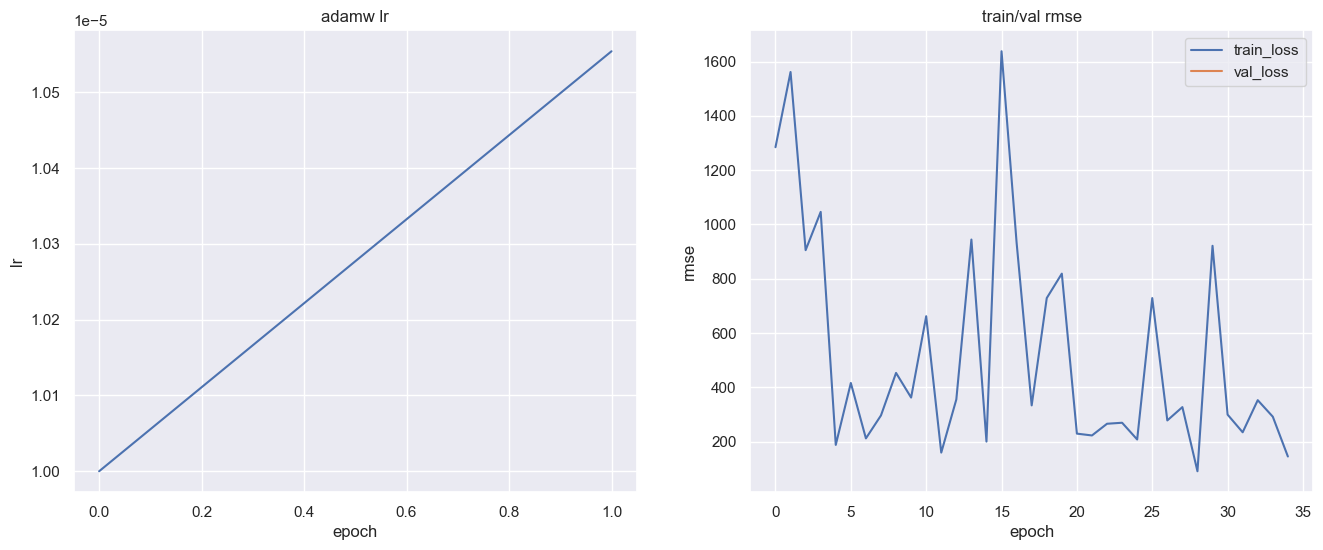

In [15]:
import seaborn as sns
sns.set()

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(range(len(scalars['lr-AdamW'])), scalars['lr-AdamW'])
plt.xlabel('epoch')
plt.ylabel('lr')
plt.title('adamw lr')

plt.subplot(1, 2, 2)
plt.plot(range(len(scalars['train_loss'])), scalars['train_loss'], label='train_loss')
plt.plot(range(len(scalars['val_loss'])), scalars['val_loss'], label='val_loss')
plt.legend()
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.title('train/val rmse')
plt.show()

c:\Users\q\Desktop\Programming\ML\venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


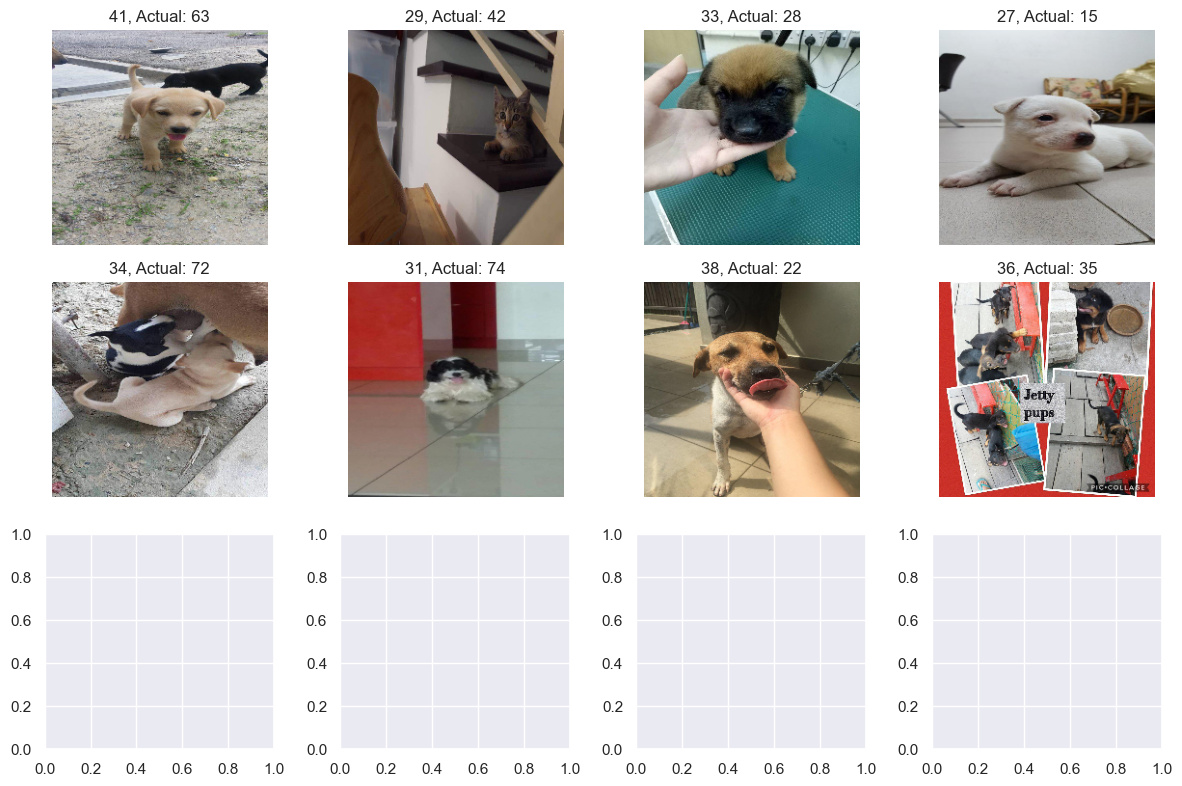

In [17]:
cols = 4

model = PawpularityModel()
checkpoint = torch.load("logs/swin_224/lightning_logs/version_1/checkpoints/best_loss.ckpt")

model.load_state_dict(checkpoint['state_dict'])

data_module = PetFinderDataModule(df, df)
dataiter = iter(data_module.val_dataloader())
batch = next(dataiter)
images, labels = batch
rows = len(images) // cols + 1

figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
for i in range(len(images)):
    image = images[i]
    label = labels[i]
    with torch.no_grad():
        prediction = model(torch.as_tensor(image, dtype=torch.float32, device='cpu').unsqueeze(0))
        prediction = prediction.cpu().numpy()[0][0]

    ax.ravel()[i].imshow(image.permute(1, 2, 0))
    ax.ravel()[i].set_axis_off()
    ax.ravel()[i].set_title(f"{round(prediction)}, Actual: {label}")

plt.tight_layout(pad=1)
plt.show()

# Predictions on Test Data

In [44]:
model = PawpularityModel()
checkpoint = torch.load("logs/swin_224/lightning_logs/version_1/checkpoints/best_loss.ckpt")
model.load_state_dict(checkpoint['state_dict'])

df_test = pd.read_csv("data/test.csv")
data_module = PetFinderDataModule(df_test, df_test, df_test)
data_loader = data_module.test_dataloader()

df_submissions = pd.DataFrame(columns=["Id", "Pawpularity"])

for images, image_ids in data_loader:
    for i in range(len(images)):
        image = images[i]
        with torch.no_grad():
            prediction = model(torch.as_tensor(image, dtype=torch.float32, device='cpu').unsqueeze(0))
            prediction = prediction.cpu().numpy()[0][0]

        df_submissions.loc[i] = [image_ids[i], prediction]

df_submissions.to_csv("data/submission.csv", index=False)

c:\Users\q\Desktop\Programming\ML\venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
